In [205]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Importing and cleaning data

In [ ]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [207]:
na_counts = train.isna().sum()
na_counts

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [208]:
train['Sex'] = train['Sex'].map({'male':0,'female':1})
train.fillna({'Embarked': train['Embarked'].mode()[0],
              'Age': train['Age'].median()}, inplace=True)
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)


## 1. Baseline model

In [209]:
features = ['Pclass','Sex','Age','Fare','Embarked_Q','Embarked_S']
X = train[features]
y = train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [210]:
baseline = LogisticRegression(max_iter=500, random_state=42)
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_val)

In [211]:
print("Baseline Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_baseline))
print("Baseline Logistic Regression Report:")
print(classification_report(y_val, y_pred_baseline))

Baseline Logistic Regression Accuracy: 0.770949720670391
Baseline Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       110
           1       0.72      0.67      0.69        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179



## 2. Feature engineering

In [212]:
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,False,True,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,False,False,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,False,True,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,False,True,Mr


In [213]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [214]:
rare_titles = ['Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer']
train['Title'] = train['Title'].replace(rare_titles,'Rare')

In [215]:
title_mapping = {"Mr":0, "Mrs":1, "Miss":2, "Rare":3 }
train['Title'] = train['Title'].map(title_mapping)

In [216]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone'] = 1*(train['FamilySize']==1)

In [217]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S,Title,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,False,True,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,False,False,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True,2,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,False,True,1,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,False,True,0,1,1


In [218]:
features = ['Pclass','Sex','Age','Fare','Title','FamilySize','IsAlone','Embarked_Q','Embarked_S']
X = train[features]
y = train['Survived']

In [219]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 3. Logistic regression

In [220]:
logistic_regression = LogisticRegression(max_iter=500, random_state=42)
logistic_regression.fit(X_train, y_train)
y_pred_logistic_regression = logistic_regression.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_logistic_regression))
print("Logistic Regression Report:")
print(classification_report(y_val, y_pred_logistic_regression))

Logistic Regression Accuracy: 0.8212290502793296
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.70      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



## 4. XGB Classifier

In [221]:
param_grid = {
    'n_estimators':[100,200],
    'max_depth':[3,4,5],
    'learning_rate':[0.05,0.1],
    'subsample':[0.8,1]
}

In [222]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
cv = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_xgb = best_model.predict(X_val)

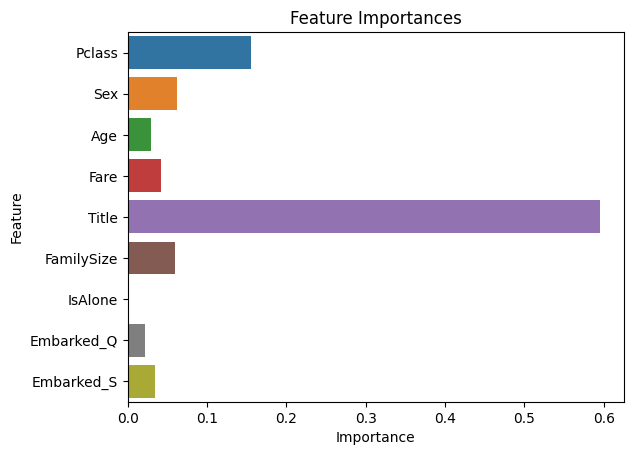

In [223]:
importances = best_model.feature_importances_
df_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

sns.barplot(data=df_importances, x='Importance', y='Feature')
plt.title("Feature Importances")
plt.show()

In [224]:
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("XGBoost Report:")
print(classification_report(y_val, y_pred_xgb))

XGBoost Accuracy: 0.8268156424581006
XGBoost Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       110
           1       0.82      0.71      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



## 5. Random Forest Classifier

In [225]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5]
}
pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True)
random_forest = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=1)
random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_val)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [226]:
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_random_forest))
print("Random Forest Report:")
print(classification_report(y_val, y_pred_random_forest))

Random Forest Accuracy: 0.8268156424581006
Random Forest Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       110
           1       0.82      0.71      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



## 6. Ensemble methods

In [227]:
proba_xgb = best_model.predict_proba(X_val)[:,1]
proba_rf = random_forest.predict_proba(X_val)[:,1]
proba_baseline = logistic_regression.predict_proba(X_val)[:,1]

proba_ensemble = (proba_xgb + proba_rf + proba_baseline) / 3
y_pred_ensemble = (proba_ensemble > 0.50).astype(int)

print("Ensemble Accuracy:", accuracy_score(y_val, y_pred_ensemble))
print("Ensemble Report:")
print(classification_report(y_val, y_pred_ensemble))

Ensemble Accuracy: 0.8268156424581006
Ensemble Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       110
           1       0.82      0.71      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



## 7. Evauating model on test set

In [ ]:
test = pd.read_csv('test.csv')
test['Sex'] = test['Sex'].map({'male':0,'female':1})
test.fillna({'Embarked': test['Embarked'].mode()[0],
              'Age': test['Age'].median()}, inplace=True)
test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)
test['Fare'] = test['Fare'].fillna(test['Fare'].median())
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
display(test['Title'].unique())
rare_titles = ['Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona']
test['Title'] = test['Title'].replace(rare_titles,'Rare')
test['Title'] = test['Title'].map(title_mapping)
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['IsAlone'] = 1*(test['FamilySize']==1)

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [229]:
X_test = test[features]

In [230]:
proba_xgb = best_model.predict_proba(X_test)[:,1]
proba_rf = random_forest.predict_proba(X_test)[:,1]
proba_baseline = logistic_regression.predict_proba(X_test)[:,1]

test_ensemble = (proba_xgb + proba_rf + proba_baseline) / 3
y_test_ensemble = (test_ensemble > 0.50).astype(int)
y_test_ensemble
test['Survived'] = y_test_ensemble
result = test[['PassengerId', 'Survived']]


In [231]:
result.reset_index(drop=True)
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [232]:
result.to_csv('submission.csv', index=False)

In [233]:
result['Survived'].value_counts()

Survived
0    270
1    148
Name: count, dtype: int64